In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np

WORK_PATH = "./"
SOURCE_PATH = os.path.join(WORK_PATH, "src")
EXPORT_PATH = os.path.join("..", "export")
DATA_PATH = os.path.join("..", "data")

sys.path.append(SOURCE_PATH)

In [24]:
import fem, tissue, numpy as np
from graphnics import FenicsGraph

TEST_NUM_NODES_EXP = 5

TEST_GRAPH = FenicsGraph()

TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],
    1: [0.010, 0.020, 0.015],
    2: [0.022, 0.013, 0.015],
    3: [0.022, 0.028, 0.015],
    4: [0.015, 0.005, 0.015],
    5: [0.015, 0.035, 0.015],
    6: [0.038, 0.005, 0.015],
    7: [0.038, 0.035, 0.015]
}
TEST_GRAPH_EDGES = [
    (0, 1, 0.004),
    (1, 2, 0.003),
    (1, 3, 0.003),
    (2, 4, 0.002),
    (2, 6, 0.003),
    (3, 5, 0.002),
    (3, 7, 0.003)
]

for node_id, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node_id, pos=pos)

for (u, v, radius) in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

TEST_GRAPH.make_mesh(n=TEST_NUM_NODES_EXP)

TEST_GRAPH.make_submeshes()

TEST_OMEGA, _ = tissue.get_Omega_rect(TEST_GRAPH, bounds = [[0, 0, 0], [0.05, 0.04, 0.03]])

X_ZERO_PLANE = tissue.AxisPlane(0, 0.0)

TEST_DOMAIN = tissue.Domain(
    TEST_GRAPH,
    TEST_OMEGA,
    Lambda_inlet_nodes = [0],
    Omega_sink_subdomain = X_ZERO_PLANE
)

TEST_CUBES_SOLVER = fem.SubCubes(
    domain = TEST_DOMAIN,
    lower_cube_bounds = [[0.0, 0.0, 0.0], [0.010, 0.010, 0.010]],
    upper_cube_bounds = [[0.033, 0.030, 0.010],[0.043, 0.040, 0.020]]
)

TEST_CUBES_SOLVER.solve(
    gamma = 3.587472583336982e-05,
    gamma_a = 8.220701444028143e-08,
    gamma_R = 8.587334091365098e-08,
    mu = 1.0e-3,
    k_t = 1.0e-10,
    P_in = 100.0 * 133.322,
    P_cvp = 1.0 * 133.322
)

TEST_CUBES_SOLVER.save_vtk("results")

Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 4911.95it/s]


/tmp/ipykernel_143151/3338705782.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  result.show()


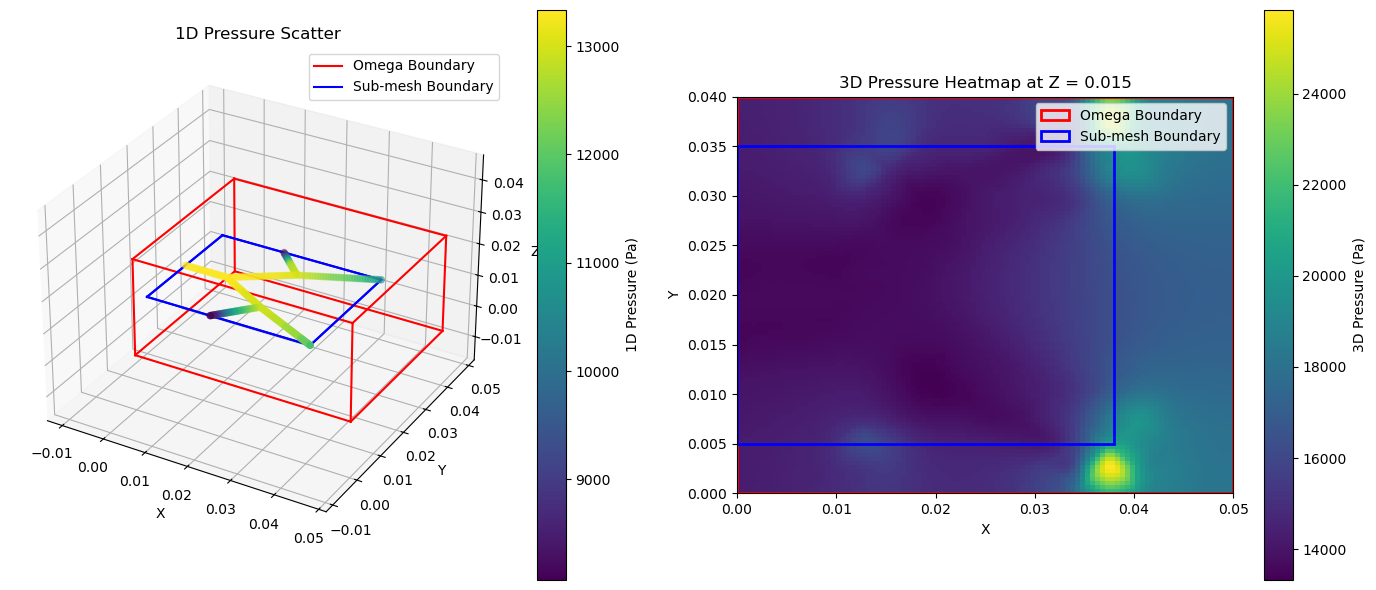

In [26]:
TEST_CUBES_SOLVER.solve(
    gamma = 3.587472583336982e-05,
    gamma_a = 8.220701444028143e-08,
    gamma_R = 8.587334091365098e-08,
    mu = 1.0e-3,
    k_t = 1.0e-10,
    P_in = 100.0 * 133.322,
    P_cvp = 1.0 * 133.322
)

import visualize
result = visualize.plot_with_boundaries(TEST_CUBES_SOLVER.uh1d, TEST_CUBES_SOLVER.uh3d)
result.show()

In [ ]:
import scipy

TARGET_FLOW = 5.0e-6
TEST_CUBES_SOLVER = fem.SubCubes(
    domain = TEST_DOMAIN,
    lower_cube_bounds = [[0.0, 0.0, 0.0], [0.010, 0.010, 0.010]],
    upper_cube_bounds = [[0.033, 0.030, 0.010],[0.043, 0.040, 0.020]]
)

def compute_flow(x, solver, domain):
    solution = solver.solve(
        gamma = x[0],
        gamma_a = x[1],
        gamma_R = x[2],
        mu = 1.0e-3,
        k_t = 1.0e-10,
        P_in = 100.0 * 133.322,
        P_cvp = 1.0 * 133.322
    )
    return solver.compute_net_flow_all_dolfin()

def objective_log(y, solver, domain, target):
    x = np.exp(y)
    val = compute_flow(x, solver, domain) - target
    return val * val

def optimization_callback(xk):
    current_params = np.exp(xk)
    print(f"Optimization iteration:")
    print(f"  Current log_params: {xk}")
    print(f"  Current parameters (gamma, gamma_a, gamma_R): {current_params}")

x0 = [1.0e-6, 1.0e-6, 1.0e-6]
log_x0 = np.log(x0)

result = scipy.optimize.minimize(
    objective_log,
    log_x0,
    args=(TEST_CUBES_SOLVER, TEST_DOMAIN, TARGET_FLOW),
    method='Nelder-Mead',
    options={'maxiter': 100},
    callback=optimization_callback
)

optimized_log_params = result.x
optimized_params = np.exp(optimized_log_params)

print("Optimized parameters:")
print("gamma =", optimized_params[0])
print("gamma_a =", optimized_params[1])
print("gamma_R =", optimized_params[2])
print("Achieved flow =", compute_flow(optimized_params, TEST_CUBES_SOLVER, TEST_DOMAIN))

In [ ]:
import numpy as np
import pandas as pd
import pytz
import datetime

X_DEFAULT = [2.570e-06, 1.412e-07, 3.147e-07, 1.543e-10]

def compute_flow(x, domain):
    solution = fem.SubCubes(
        domain=domain,
        gamma=x[0],
        gamma_a=x[1],
        gamma_R=x[2],
        mu=1.0e-3,
        k_t=1.0e-10,
        k_v=x[3],
        P_in=100.0 * 133.322,
        P_cvp=1.0 * 133.322,
        lower_cube_bounds=[[0.0, 0.0, 0.0], [0.010, 0.010, 0.010]],
        upper_cube_bounds=[[0.033, 0.030, 0.010], [0.043, 0.040, 0.020]]
    )
    data = [
        solution.compute_net_flow_all_dolfin(),
        solution.compute_lower_cube_flux_out(),
        solution.compute_upper_cube_flux_in(),
        solution.compute_upper_cube_flux_out(),
        solution.compute_upper_cube_flux()
    ]
    return data

def sweep_variable(variable_name, variable_values, default, domain, directory = None):
    variable_index = -1
    rows = []
    match variable_name:
        case "gamma": variable_index = 0
        case "gamma_a": variable_index = 1
        case "gamma_R": variable_index = 2
        case "k_v": variable_index = 3
        case _: raise ValueError("Invalid variable choice")
    for value in variable_values:
        x = default[:]
        x[variable_index] = value
        results = compute_flow(x, domain)
        rows.append({
            variable_name: value,
            "net_flow": results[0],
            "lower_cube_flux_out": results[1],
            "upper_cube_flux_in": results[2],
            "upper_cube_flux_out": results[3],
            "upper_cube_flux": results[4]
        })
    df = pd.DataFrame(rows).set_index(variable_name)
    if directory is not None:
        os.makedirs(directory, exist_ok=True)
        cst = pytz.timezone("America/Chicago")
        now = datetime.datetime.now(cst)
        timestamp = now.strftime("%Y%m%d_%H%M")
        filename = os.path.join(directory, f"{variable_name}_sweeps_{timestamp}.csv")
        df.to_csv(filename)
    return df

data = sweep_variable("gamma", np.logspace(-10, 2, 50), X_DEFAULT, TEST_DOMAIN, directory = EXPORT_PATH)
# data = pd.read_csv(filename, index_col = 0)

Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 2021.05it/s]


Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 2508.51it/s]


Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 2671.58it/s]


Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 2327.85it/s]


Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 2357.00it/s]


Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 2054.94it/s]


Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 2143.74it/s]


Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 2271.98it/s]


Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 2429.62it/s]


Averaging over 224 cells: 100%|█████████████| 224/224 [00:00<00:00, 2599.11it/s]


In [ ]:
data = pd.read_csv(os.path.join(EXPORT_PATH, "gamma_sweeps_20250402_1545.csv"), index_col = 0)

In [ ]:
data

,net_flow,lower_cube_flux_out,upper_cube_flux_in,upper_cube_flux_out,upper_cube_flux
gamma,,,,,
1.000000e-10,0.000005,0.000001,-0.000002,0.000003,1.061173e-06
2.154435e-09,0.000005,0.000001,-0.000002,0.000003,1.062734e-06
4.641589e-08,0.000005,0.000001,-0.000002,0.000004,1.094307e-06
1.000000e-06,0.000005,0.000001,-0.000003,0.000005,1.452627e-06
2.154435e-05,0.000005,0.000001,-0.000006,0.000009,2.226002e-06
4.641589e-04,0.000004,0.000001,-0.000006,0.000008,2.009128e-06
1.000000e-02,0.000004,0.000001,-0.000002,0.000003,5.721161e-07
2.154435e-01,0.000004,0.000001,-0.000001,0.000002,4.489882e-07
4.641589e+00,0.000004,0.000001,-0.000001,0.000002,4.799252e-07


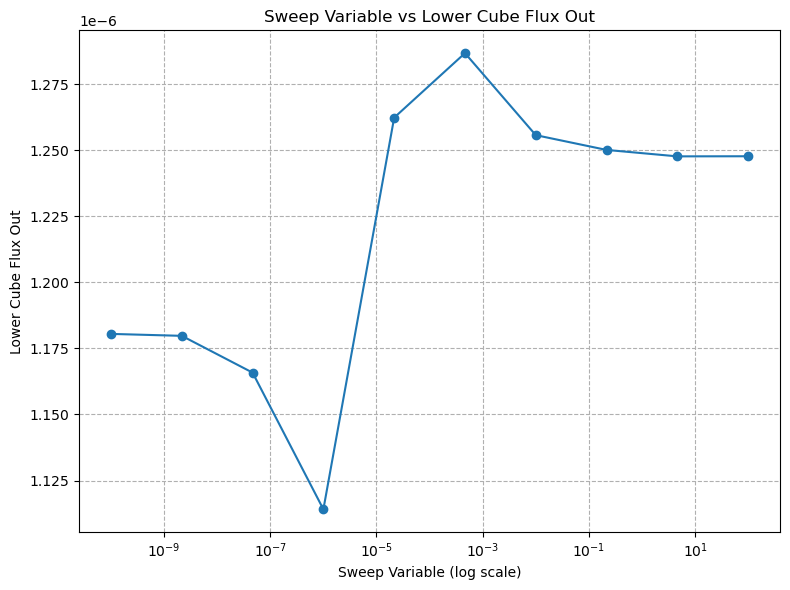

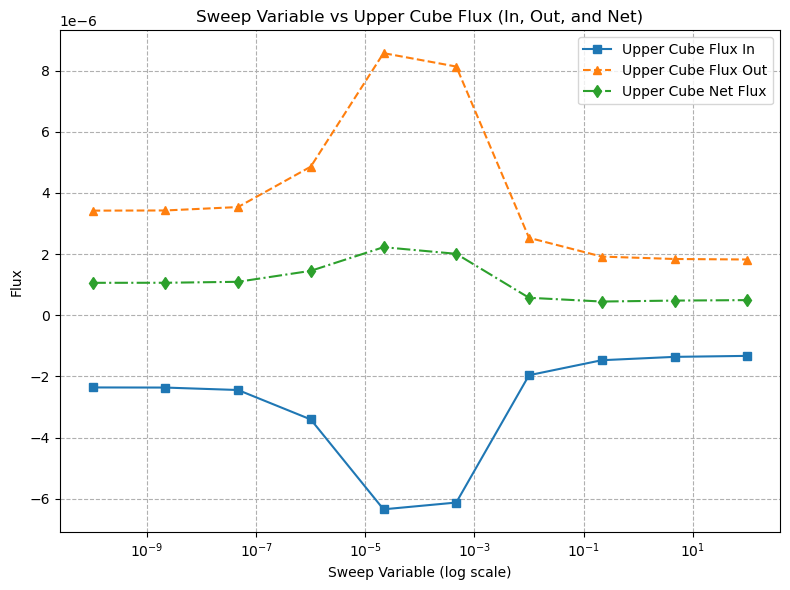

In [ ]:
import matplotlib.pyplot as plt

def plot_flow_data_semilog(df):
    variable = df.index.values

    plt.figure(figsize=(8, 6))
    plt.semilogx(variable, df['lower_cube_flux_out'], marker='o', linestyle='-')
    plt.xlabel('Sweep Variable (log scale)')
    plt.ylabel('Lower Cube Flux Out')
    plt.title('Sweep Variable vs Lower Cube Flux Out')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.semilogx(variable, df['upper_cube_flux_in'], marker='s', linestyle='-', label='Upper Cube Flux In')
    plt.semilogx(variable, df['upper_cube_flux_out'], marker='^', linestyle='--', label='Upper Cube Flux Out')
    plt.semilogx(variable, df['upper_cube_flux'], marker='d', linestyle='-.', label='Upper Cube Net Flux')
    plt.xlabel('Sweep Variable (log scale)')
    plt.ylabel('Flux')
    plt.title('Sweep Variable vs Upper Cube Flux (In, Out, and Net)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

plot_flow_data_semilog(data)

In [ ]:
cst = pytz.timezone("America/Chicago")
now = datetime.datetime.now(cst)
timestamp = now.strftime("%Y%m%d_%H%M")
output_dir = os.path.join(EXPORT_PATH, f"output_sweeps_{timestamp}")
os.makedirs(output_dir, exist_ok=True)

df_results = sweep_for_param('gamma', TEST_SWEEP_CONFIG, TEST_SWEEP_DEFAULT, output_dir)
plot_results(df_results, TEST_SWEEP_CONFIG, output_dir)
save_data_to_csv(df_results, output_dir)

[autoreload of fem.velo failed: Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 309, in update_function
    setattr(old, name, getattr(new, name))
ValueError: save_vtk() requires a code object with 0 free vars, not 1
]


NameError: name 'sweep_for_param' is not defined

In [18]:
df_results, sweep_configs = perform_all_sweeps(num_points=50)
plot_results(df_results, sweep_configs, output_dir)
save_data_to_csv(df_results, output_dir)

NameError: name 'perform_all_sweeps' is not defined